# Rumusan Masalah
Rumusan penelitian ini adalah "Bagaimana prosedur yang dilakukan untuk Analisis Statistik dalam Pembayaran Digital dengan Menggunakan Metode Klasifikasi". Di era golabal seperti sekarang ini pembayaran digital memiliki kepentingan besar bagi pebisnis maupun bagi konsumen. Pembayaran digital telah muncul sebagai alat penting untuk memajukan inklusi keuangan karena hal itu dapat mengurangi biaya penyediaan layanan keuangan dan meningkatkan keamanan dan kenyamanan saat melakukan transaksi pembayaran. Dampak yang mungkin terjadi akibat transaksi ini adalah penumpukan data secara terus menerus (big data), karena hal ini akan memungkinkan konvergensi pembayaran yang lebih besar. Dengan demikian, dibutuhkan kemampuan untuk mengolah data yang mempuni dan proses analitik berkembang untuk membuat keputusan yang efisien.

# Tujuan Penelitian
Pada penelitian ini saya tertarik untuk mempelajari karakteristik pelanggan yang membuat kredit di bank pada bulan berikutnya. Data yang diberikan sekitar 24000 pelanggan dengan karakteristik berbeda, di mana 15945 di antaranya tidak pernah melewatkan pembayaran dan 8055 di antaranya setidaknya melewati pembayaran sekali. Sebagai Peneliti, saya untuk memprediksi 6000 pelanggan baru dengan jenis karakteristik tertentu yang diberikan pada Tabel [1] apakah mereka melewatkan pembayaran setidaknya satu kali selama periode enam bulan. Secara garis besar penelitian sederhana ini mencakup beberapa pembahasan sebagai berikut:

*Memilih variabel yang menjadi acuan untuk melakukan analisis dan memberikan justifikasi,

*Menentukan metodologi yang digunakan untuk analisis dan menjelaskan alasan mengapa memilih metode tersebut (disebutkan dan jelaskan teorinya secara singkat);

*Memperlihatkan hasil eksplorasi data dan menjelaskan hasil analisis,

*Diakhir pembahasan diberikan saran berdasarkan hasil penelitian.

In [1]:
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

import gc
from datetime import datetime 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb
import xgboost as xgb


# to ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Parameter

In [2]:
RFC_METRIC = 'gini'         # metrik digunakan dengan Random Forrest Classifier
NUM_ESTIMATORS = 100        # jumlah estimator yang digunakan untuk Random Forrest Classifier
NO_JOBS = 4                 # jumlah pekerjaan paralel yang digunakan untuk Random Forrest Classifier

#VALIDASI
VALID_SIZE = 0.20           # validasi sederhana menggunakan train_test_split

#VALIDASI SILANG
NUMBER_KFOLDS = 5           # jumlah KFolds untuk validasi silang

RANDOM_STATE = 2021

MAX_ROUNDS = 1000           # iterasi lgb
EARLY_STOP = 50             # lgb berhenti lebih awal
OPT_ROUNDS = 1000           # untuk disesuaikan berdasarkan putaran validasi terbaik
VERBOSE_EVAL = 50           # cetak hasil metrik

IS_LOCAL = False

In [3]:
data_df = pd.read_csv('UCI_Credit_Card.csv')
data_df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [4]:
print('rows:', data_df.shape[0], 'columns:', data_df.shape[1])

rows: 30000 columns: 25


In [5]:
data_df.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


Ada 30.000 klien kartu kredit yang berbeda. Nilai rata-rata untuk jumlah batas kartu kredit adalah 167.484. Terlihat bahwa standar deviasi sangat besar, nilai maksnya 1M. Tingkat pendidikan sebagian besar adalah sekolah pascasarjana dan universitas. Sebagian besar klien sudah menikah sedangkan yang berstatus lajang lebih jarang. Usia rata-rata adalah 35,5 tahun, dengan standar deviasi 9,2. Karena nilai 0 untuk pembayaran standar berarti 'not default' dan nilai 1 berarti 'default', rata-rata 0,221 berarti bahwa ada 22,1% kontrak kartu kredit yang akan default bulan depan (bagian ini selanjutnya akan diverifikasi dengan analisis lebih lanjut).

# Data Yang Hilang
Memeriksa apakah data ada yang hilang 

In [6]:
total = data_df.isnull().sum().sort_values(ascending = False)
percent = (data_df.isnull().sum()/data_df.isnull().count()*100).sort_values(ascending = False)
pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).transpose()

,ID,BILL_AMT2,PAY_AMT6,PAY_AMT5,PAY_AMT4,PAY_AMT3,PAY_AMT2,PAY_AMT1,BILL_AMT6,BILL_AMT5,...,PAY_5,PAY_4,PAY_3,PAY_2,PAY_0,AGE,MARRIAGE,EDUCATION,SEX,default.payment.next.month
Total,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


tidak ada data yang hilang

# Proporsi Sebaran Data
Memeriksa ketidakseimbangan data, hal ini dapat mempengaruhi variabel respon

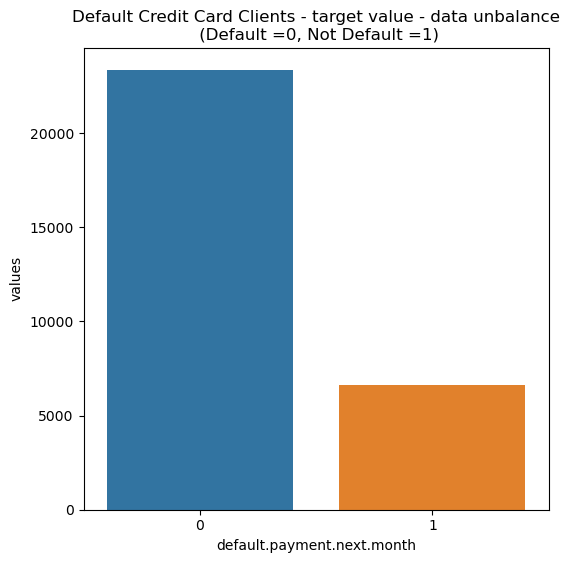

In [7]:
temp = data_df["default.payment.next.month"].value_counts()
df = pd.DataFrame({'default.payment.next.month': temp.index, 'values': temp.values})
plt.figure(figsize = (6,6))
plt.title('Default Credit Card Clients - target value - data unbalance\n (Default =0, Not Default =1)')
sns.set_color_codes("pastel")
sns.barplot(x='default.payment.next.month', y='values',data=df)
locs, labels = plt.xticks()
plt.show()

Sejumlah 6.636 dari 30.000 (atau 22%) klien akan mengalami default bulan depan. Data tidak memiliki ketidakseimbangan besar sehubungan dengan nilai target (default.payment.next.month). Jadi, sejauh ini tidak ada masalah yang berarti dengan dataset yang akan digunakan.

# Eksplorasi Data

Melakukan analisa sederhana mengenai batasan kredit yang biasa diberikan kepada klien(Konsumen)

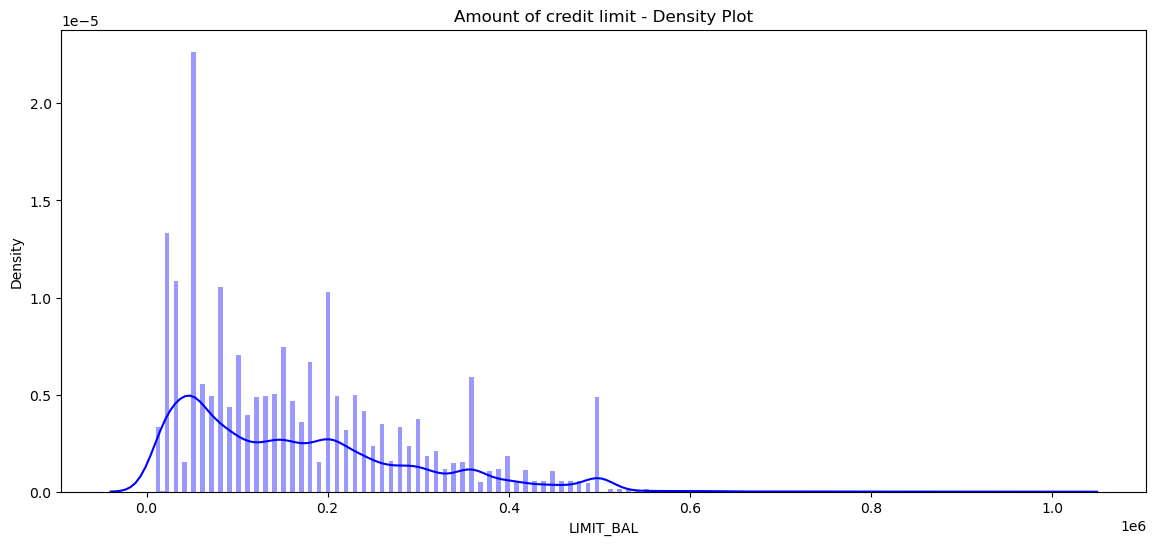

In [8]:
plt.figure(figsize = (14,6))
plt.title('Amount of credit limit - Density Plot')
sns.set_color_codes("pastel")
sns.distplot(data_df['LIMIT_BAL'],kde=True,bins=200, color="blue")
plt.show()

Kelompok terbesar jumlah batas kredit tampaknya berkisar 50 ribuan.

In [9]:
data_df['LIMIT_BAL'].value_counts().shape

(81,)

ada 81 nilai berbeda untuk jumlah batas kredit

In [10]:
data_df['LIMIT_BAL'].value_counts().head(5)

50000.0     3365
20000.0     1976
30000.0     1610
80000.0     1567
200000.0    1528
Name: LIMIT_BAL, dtype: int64

Ternyata benar, bahwa jumlah kartu kredit terbesar adalah dengan batas 50.000 (3365), diikuti oleh 20.000 (1976) dan 30.000 (1610), dst.

# Klasifikasi Batasan Kredit
Memvisualisasikan plot kepadatan untuk jumlah batas kredit (LIMIT_BAL), dikelompokkan berdasarkan pembayaran standar bulan depan. (Nb: Hal ini dilakukan untuk melihat sebaran data, kenormalan data tersebut)

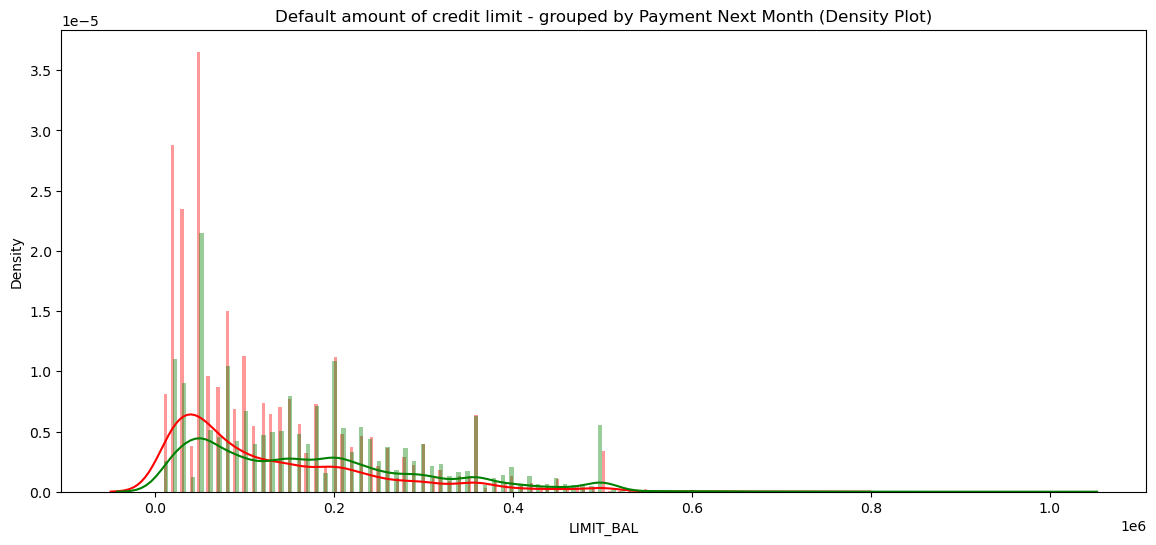

In [11]:
class_0=data_df.loc[data_df['default.payment.next.month']==0]['LIMIT_BAL']
class_1 = data_df.loc[data_df['default.payment.next.month']==1]['LIMIT_BAL']

plt.figure(figsize = (14,6))
plt.title('Default amount of credit limit - grouped by Payment Next Month (Density Plot)')
sns.set_color_codes('pastel')
sns.distplot(class_1,kde=True,bins=200, color='red')
sns.distplot(class_0,kde=True,bins=200, color='green')
plt.show()

Sebagian besar default adalah untuk batas kredit 0-100.000 (dan kepadatan untuk interval ini lebih besar untuk default daripada non-default). Jumlah default yang lebih besar adalah untuk jumlah 50.000, 20.000 dan 30.000.

# Batas Kredit vs Jenis Kelamin
Melakukan analisis distribusi Batas Kredit vs Jenis Kelamin,
untuk Jenis Kelamin, 1 = Pria dan 2 = Wanita

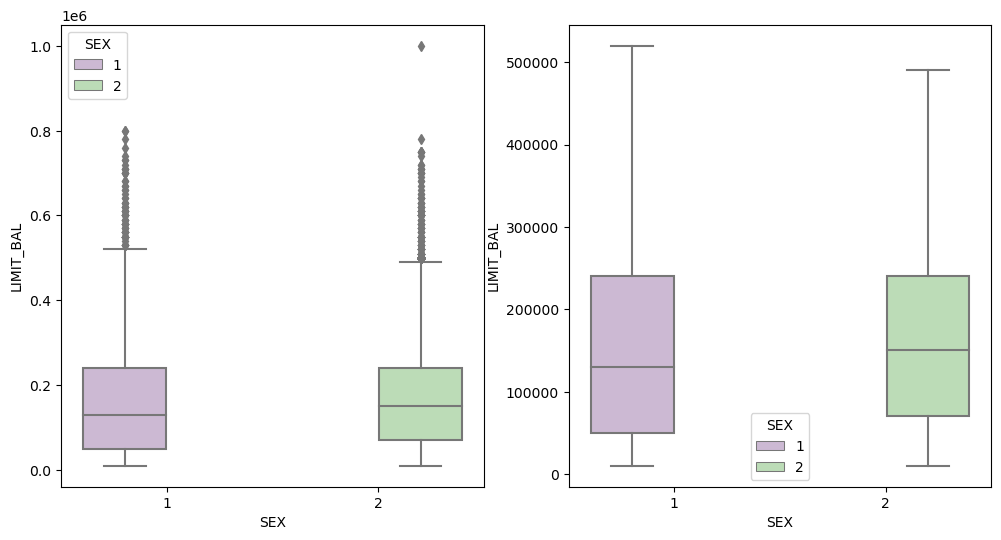

In [12]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
s = sns.boxplot(ax =ax1, x='SEX', y='LIMIT_BAL', hue='SEX', data=data_df, palette='PRGn',showfliers=True)
s = sns.boxplot(ax =ax2, x='SEX', y='LIMIT_BAL', hue='SEX', data=data_df, palette='PRGn',showfliers=False)
plt.show();

Batas jumlah kredit cukup seimbang antara jenis kelamin. Laki-laki memiliki Q2 sedikit lebih kecil dan lebih besar Q3 dan Q4 dan rata-rata lebih rendah. Ditemukan bahwa wanita memiliki nilai max outlier yang lebih besar hingga kisaran (1M dolar).

# Check Korelasi
untuk data yang bernilai numerik, biasanya dilakukan analisis korelasi.
oleh sebab itu, berikut ini di periksa kolerasi jumlah laporan tagihan pada bulan April - september 2005

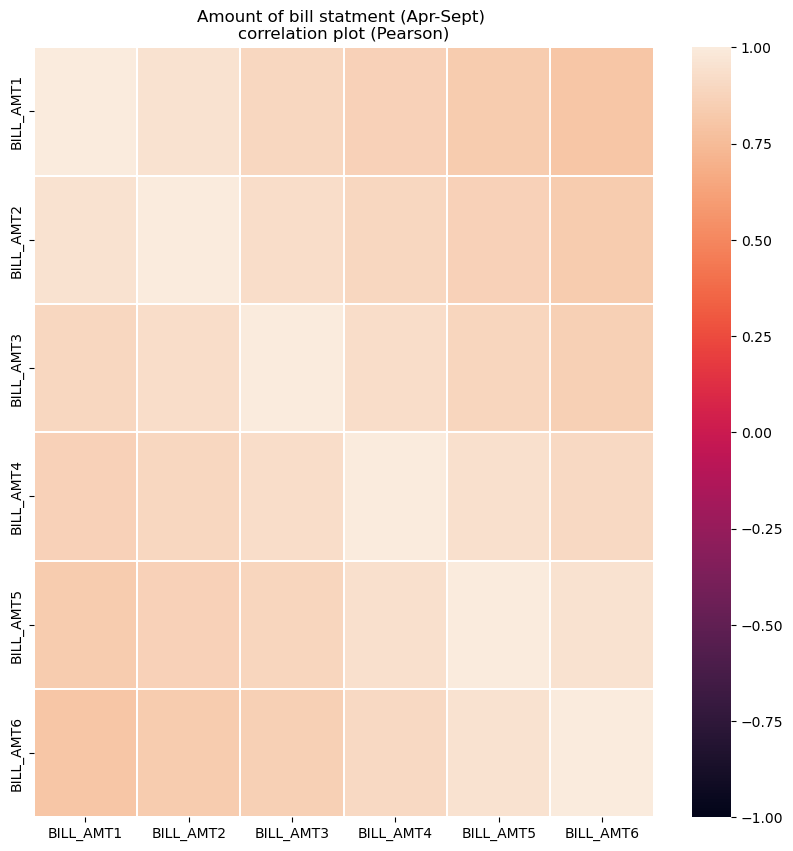

In [13]:
var = ['BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6']

plt.figure(figsize=(10,10))
plt.title('Amount of bill statment (Apr-Sept) \ncorrelation plot (Pearson)')
corr = data_df[var].corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,vmin=-1, vmax=1)
plt.show()

Dari gambar terlihat bahwa adanya korelasi jumlah tagihan disetiap bulannya. Korelasi terendah ada pada September dan April. Oleh karena itu, berikutnya juga dilakukan pemeriksaan korelasi Jumlah pembayaran sebelumnya pada bulan April - September 2005.

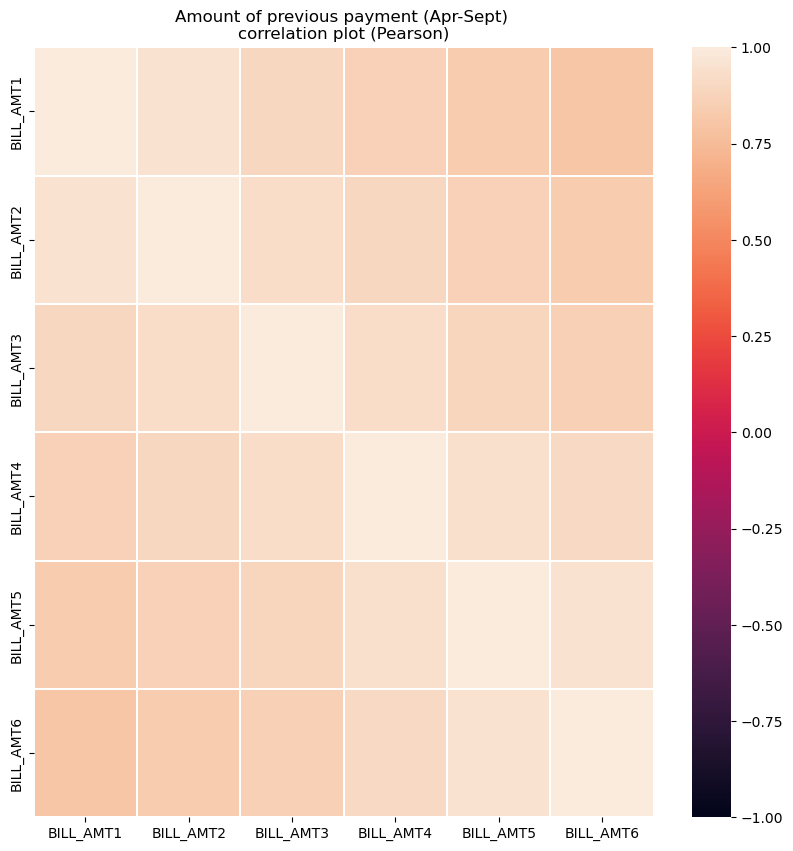

In [14]:
r = ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5']

plt.figure(figsize = (10,10))
plt.title('Amount of previous payment (Apr-Sept) \ncorrelation plot (Pearson)')
corr = data_df[var].corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,vmin=-1, vmax=1)
plt.show()

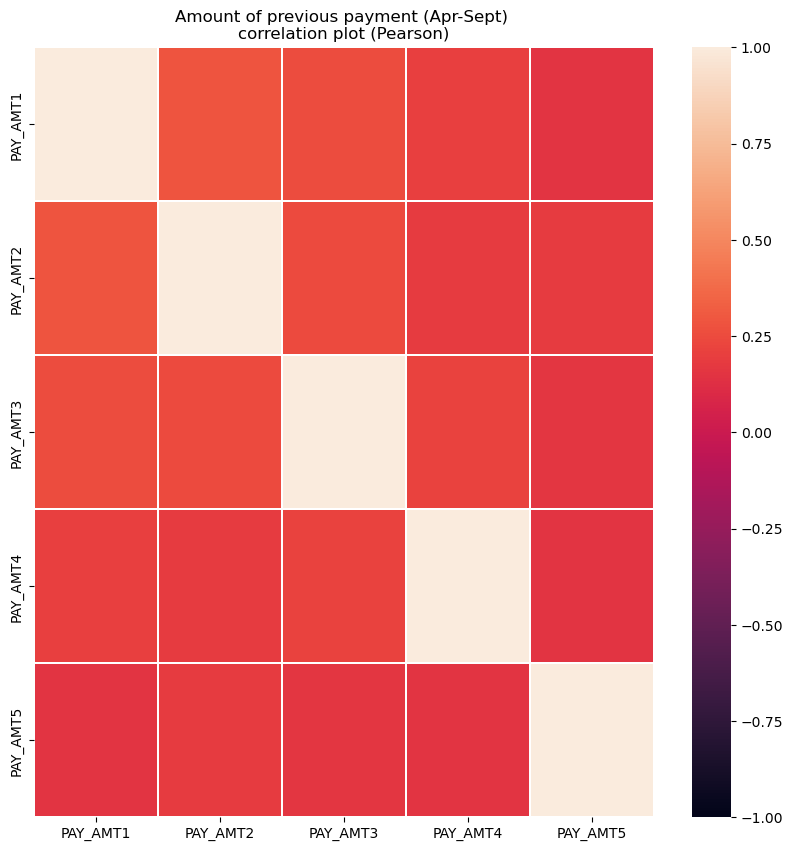

In [15]:
var = ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5']

plt.figure(figsize = (10,10))
plt.title('Amount of previous payment (Apr-Sept) \ncorrelation plot (Pearson)')
corr = data_df[var].corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,vmin=-1, vmax=1)
plt.show()

Ternyata tidak ada korelasi antara jumlah pembayaran sebelumnya untuk April-September 2005. Maka diperiksa juga korelasi antara status Pelunasan pada bulan April - September 2005.

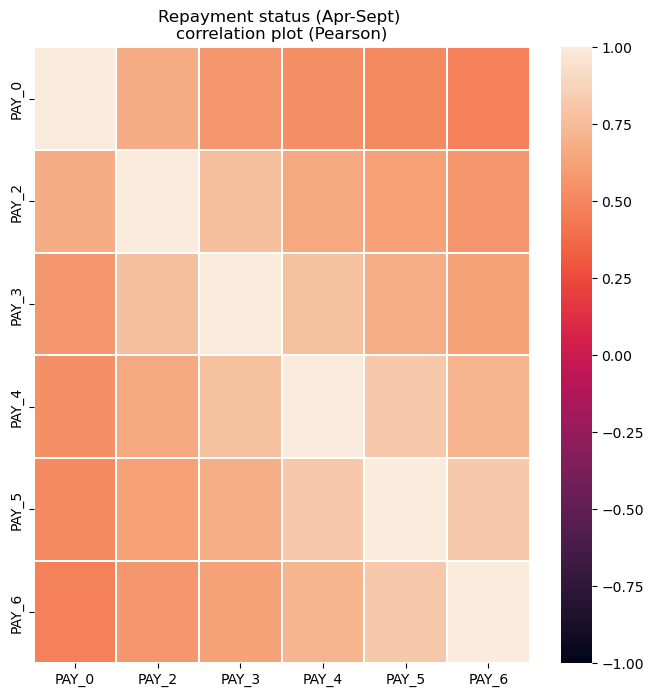

In [16]:
var = ['PAY_0','PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

plt.figure(figsize = (8,8))
plt.title('Repayment status (Apr-Sept) \ncorrelation plot (Pearson)')
corr = data_df[var].corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,vmin=-1, vmax=1)
plt.show()

Sejalan dengan korelasi jumlah tagihan, korelasi pembayaran juga menurun setiap bulannya. (Korelasi terendah ada pada September dan April).

# Jenis Kelamin, Pendidikan, Usia dan Pernikahan¶
Dibawah ini diperlihatkan distribusi jenis kelamin, pendidikan, usia dan pernikahan. Dimulai dengan menunjukkan Boxplot dengan distribusi usia yang dikelompokkan berdasarkan status pernikahan dan jenis kelamin.

Makna status pernikahan adalah:

0 : unknown (bisa diasumsikan lainnya juga),

1 : menikah,

2 : tunggal,

3 : lainnya,

Arti seks adalah:

1 : pria
2 : wanita

In [17]:
def boxplot_variation(feature1, feature2, feature3, width=16):
    fig, ax1 = plt.subplots(ncols=1, figsize=(width,6))
    s = sns.boxplot(ax = ax1, x=feature1, y=feature2, hue=feature3,
                data=data_df, palette="PRGn",showfliers=False)
    s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.show();

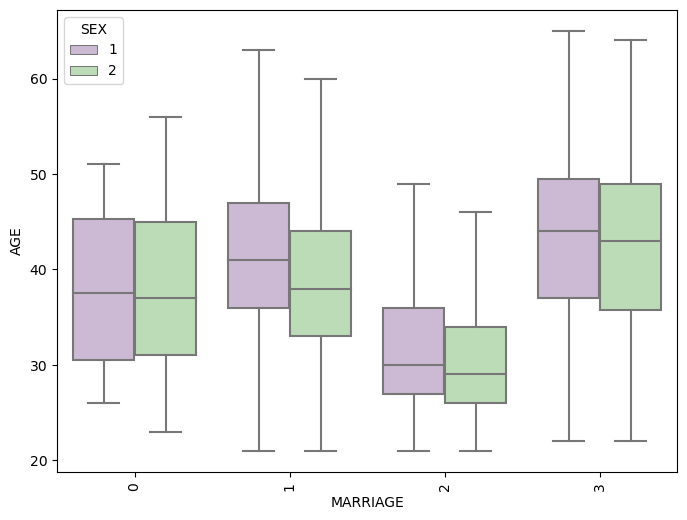

In [18]:
boxplot_variation('MARRIAGE','AGE', 'SEX',8)

Seperti halnya status pernikahan 3 (lainnya), saat nilai rata-rata lebih dari 40 dan nilai Q4 lebih dari 60 berarti sebagian besar konsumen sudah menikah atau bercerai. Sementara status Menikah 0 tidak dapat ditentukan atau bercerai, karena nilai Q1 di atas nilai untuk menikah dengan kedua jenis kelamin.

Pria yang menikah memiliki usia rata-rata di atas wanita yang sudah menikah. Laki-laki yang belum menikah memiliki nilai rata-rata untuk usia di atas wanita yang belum menikah juga tetapi lebih dekat. Nilai Q3 dan Q4 untuk pria yang sudah menikah berada di atas nilai yang sesuai untuk wanita yang sudah menikah.

Melalui Boxplot tersebut terlihat dengan distribusi usia yang dikelompokkan berdasarkan pendidikan dan pernikahan.

Arti status pendidikan adalah:

1: sekolah pascasarjana

2: universitas

3: sekolah menengah

4: lainnya

5: tidak diketahui

6: tidak tahu

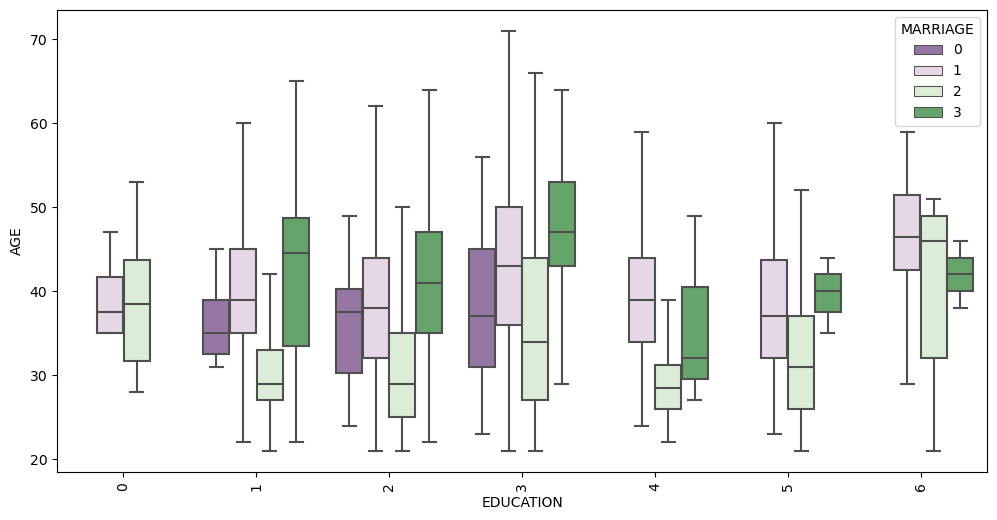

In [19]:
boxplot_variation('EDUCATION','AGE', 'MARRIAGE',12)

# Batas Usia, Jenis Kelamin, dan Jumlah Kredit¶
Berikut diperlihatkan boxplot dengan distribusi batas jumlah kredit yang dikelompokkan berdasarkan usia dan jenis kelamin.

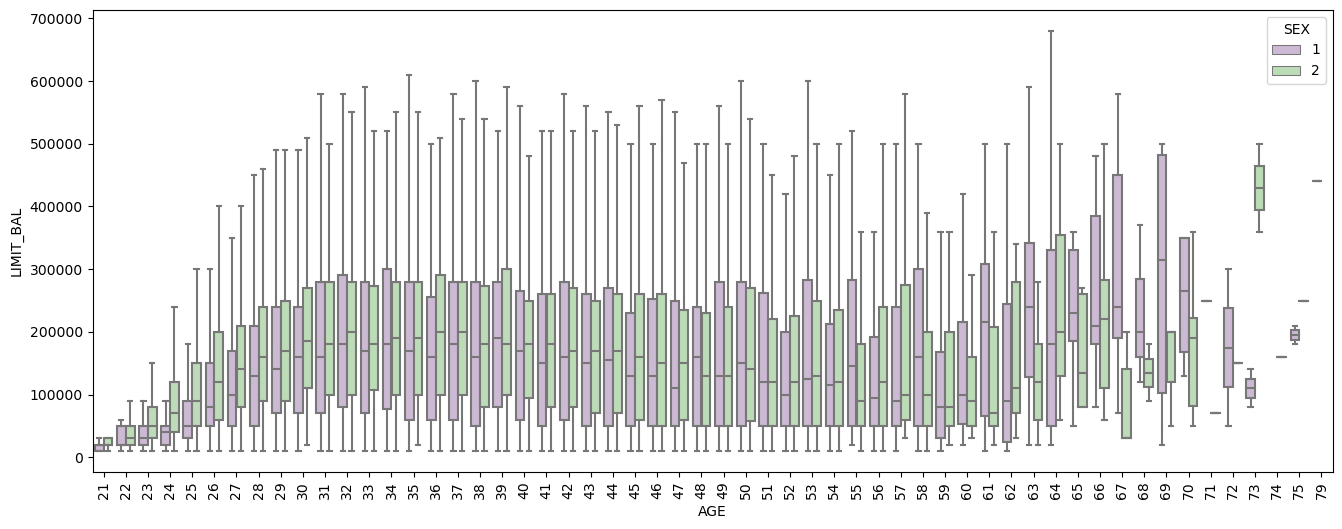

In [20]:
boxplot_variation('AGE','LIMIT_BAL', 'SEX',16)

Disimpulkan bahwa, nilai Q3 dan Q4 meningkat untuk pria dan wanita dengan usia sampai 35 tahun dan kemudian berosilasi dan mencapai maksimum Q4 untuk pria pada usia 64. Nilai rata-rata umumnya lebih kecil untuk pria daripada wanita, dengan beberapa pengecualian, misalnya pada usia 39, 48, hingga sekitar 60 tahun, di mana nilai rata-rata untuk pria umumnya lebih besar daripada wanita.


# Status Perkawinan, Pendidikan, dan Batasan Kredit¶
Berikut ini diperlihatkan boxplot dengan distribusi batas jumlah kredit yang dikelompokkan berdasarkan status pernikahan dan tingkat pendidikan.

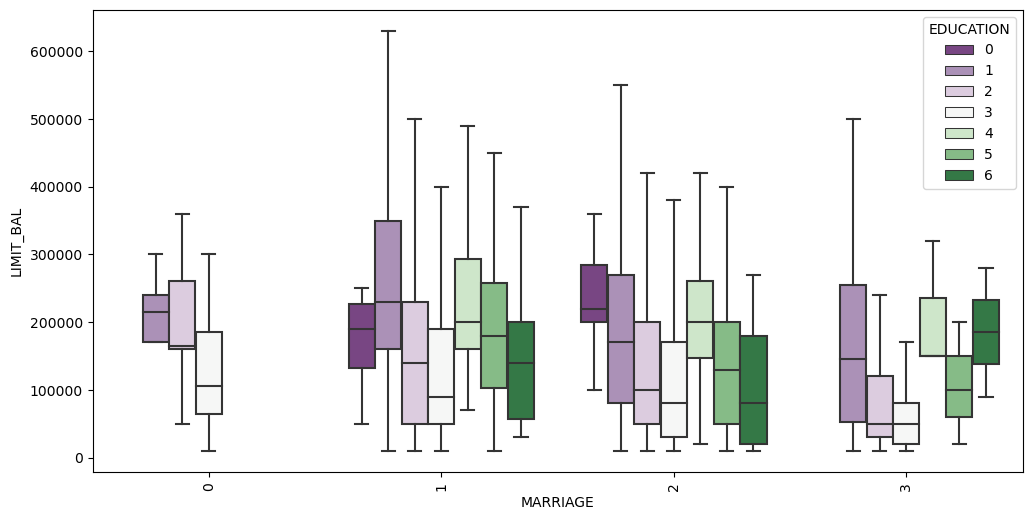

In [21]:
boxplot_variation('MARRIAGE','LIMIT_BAL', 'EDUCATION',12)

Dari Boxplot diatas dapat disimpulkan bahwa tingkat pendidikan dan status pernikahan sedikit banyaknya mempengaruhi batasan kredit setiap klien atau konsumen.

# Permodelan Prediksi 

# Tentukan Variabel Prediktor dan Respon¶
Pada tahap ini adalah penentuan variabel prediktor dan respon (target). Meninjau variabel kategorikal jika ada, kebetulan pada kasus ini tidak ada fitur kategorikal.

In [22]:
target = 'default.payment.next.month'
predictors = [  'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 
                'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 
                'BILL_AMT1','BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
                'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

# Split Data Training dan Data Validasi
memisahkan data training dan data Validasi

In [23]:
train_df, val_df = train_test_split(data_df, test_size=VALID_SIZE, random_state=RANDOM_STATE, shuffle=True)
#sebaiknya juga membuat salinan train_df dan val_df untuk penggunaan nanti

In [24]:
train_df_bkp = train_df.copy()
val_df_bkp = val_df.copy()

In [25]:
# Penerapan Random Forest Classifier 

# Random Forest Classifier

In [26]:
clf = RandomForestClassifier(n_jobs=NO_JOBS,
                             random_state=RANDOM_STATE,
                             criterion=RFC_METRIC,
                             n_estimators=NUM_ESTIMATORS,
                             verbose=False)

In [27]:
# Melakukan pelatihan model Random Forest Classifier menggunakan data train_df.

In [28]:
clf.fit(train_df[predictors], train_df[target].values)

RandomForestClassifier(n_jobs=4, random_state=2021, verbose=False)

In [29]:
# Melakukan prediksi
preds = clf.predict(val_df[predictors])

# Features importance

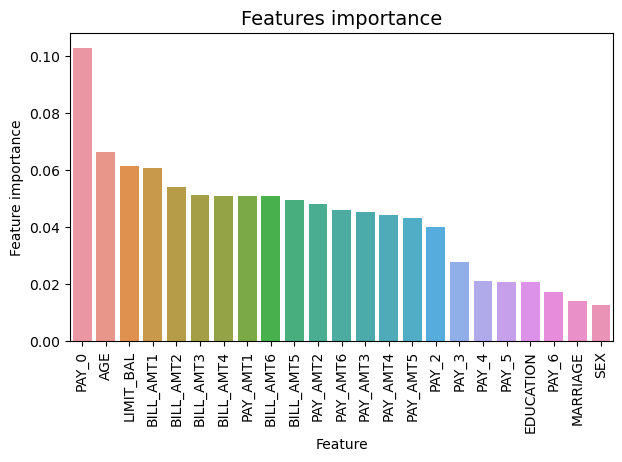

In [30]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()  

Fitur yang paling penting adalah PAY_0, AGE, BILL_AMT1, LIMIT_BAL, BILL_AMT2, BILL_AMT3.

# Confusion Matrix

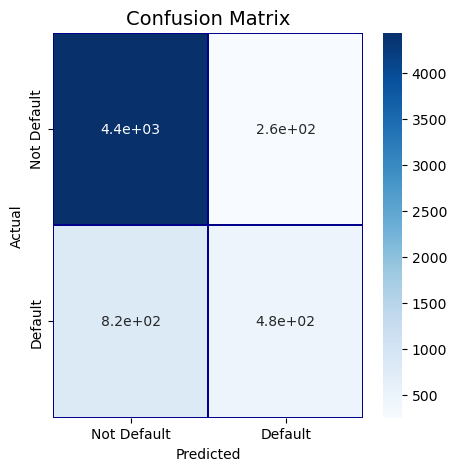

In [31]:
cm = pd.crosstab(val_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Default', 'Default'],
            yticklabels=['Not Default', 'Default'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

Dapat juga di lakukan dengan menghitung persentasi area di bawah kurva.

In [32]:
roc_auc_score(val_df[target].values, preds)

0.65701053075027

Skor ROC-AUC yang diperoleh dengan Random Forrest Classifier adalah 0,66.

Berikutnya digunakan untuk Random Forrest Classifier variabel dummi untuk fitur-fitur kategori. Dapat dimulai dengan mendefinisikan fitur-fitur kategorikal.

# Random Forest with OneHotEncoder

In [33]:
cat_features = ['EDUCATION', 'SEX', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

In [34]:
train_f_df = pd.get_dummies(train_df_bkp, columns = cat_features)
val_f_df = pd.get_dummies(val_df_bkp, columns = cat_features)

In [35]:
print("Default of Credit Card Clients train data -  rows:",train_f_df.shape[0]," columns:", train_f_df.shape[1])
print("Default of Credit Card Clients val  data -  rows:",val_f_df.shape[0]," columns:", val_f_df.shape[1])

Default of Credit Card Clients train data -  rows: 24000  columns: 92
Default of Credit Card Clients val  data -  rows: 6000  columns: 88


Karena data training dan validasi tidak memiliki jumlah kolom yang sama, maka kita perlu untuk menyelaraskannya.

In [36]:
train_fa_df, val_fa_df = train_f_df.align(val_f_df, join='outer', axis=1, fill_value=0)

In [37]:
print("Default of Credit Card Clients train data -  rows:",train_fa_df.shape[0]," columns:", train_fa_df.shape[1])
print("Default of Credit Card Clients val  data -  rows:",val_fa_df.shape[0]," columns:", val_fa_df.shape[1])

Default of Credit Card Clients train data -  rows: 24000  columns: 93
Default of Credit Card Clients val  data -  rows: 6000  columns: 93


In [38]:
train_fa_df.head(5)

,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,EDUCATION_0,EDUCATION_1,EDUCATION_2,...,PAY_6_8,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,SEX_1,SEX_2,default.payment.next.month
21750,24,6071.0,0.0,3308.0,2527.0,1076.0,1164.0,0,0,1,...,0,0.0,3308.0,2527.0,1079.0,1167.0,1974.0,0,1,0
15992,44,49644.0,0.0,0.0,0.0,0.0,0.0,0,0,1,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
17359,49,75853.0,78983.0,133236.0,6574.0,2924.0,-626.0,0,0,1,...,0,6065.0,70538.0,6634.0,10.0,0.0,0.0,0,1,0
11540,44,48850.0,0.0,0.0,0.0,0.0,0.0,0,1,0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0
10794,35,16528.0,19347.0,18600.0,19000.0,19000.0,20000.0,0,0,1,...,0,3400.0,0.0,1000.0,0.0,1000.0,0.0,0,1,0


In [39]:
val_fa_df.head(5)

,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,EDUCATION_0,EDUCATION_1,EDUCATION_2,...,PAY_6_8,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,SEX_1,SEX_2,default.payment.next.month
4358,25,0.0,0.0,0.0,0.0,0.0,550.0,0,1,0,...,0,0.0,0.0,0.0,0.0,550.0,0.0,0,1,1
17095,25,72120.0,71702.0,71532.0,71222.0,47538.0,48879.0,0,1,0,...,0,2600.0,2700.0,2200.0,2000.0,3443.0,2000.0,0,1,0
7541,22,19875.0,19273.0,21133.0,19121.0,19663.0,20235.0,0,0,1,...,0,0.0,2500.0,0.0,1000.0,1050.0,600.0,1,0,1
4776,25,61943.0,61458.0,57045.0,50652.0,48476.0,49815.0,0,0,0,...,0,2215.0,1900.0,1800.0,1920.0,2300.0,1485.0,0,1,0
3549,28,20914.0,29303.0,2515.0,7885.0,14493.0,2113.0,0,0,1,...,0,10087.0,2522.0,7951.0,14493.0,2120.0,3027.0,1,0,0


Menentukan Daftar Target dan Prediktor

In [40]:
target_f = 'default.payment.next.month'
predictors_f = ['AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
       'BILL_AMT5', 'BILL_AMT6', 'EDUCATION_0', 'EDUCATION_1',
       'EDUCATION_2', 'EDUCATION_3', 'EDUCATION_4', 'EDUCATION_5',
       'EDUCATION_6', 'LIMIT_BAL', 'MARRIAGE_0', 'MARRIAGE_1',
       'MARRIAGE_2', 'MARRIAGE_3', 'PAY_0_-1', 'PAY_0_-2', 'PAY_0_0',
       'PAY_0_1', 'PAY_0_2', 'PAY_0_3', 'PAY_0_4', 'PAY_0_5', 'PAY_0_6',
       'PAY_0_7', 'PAY_0_8', 'PAY_2_-1', 'PAY_2_-2', 'PAY_2_0', 'PAY_2_1',
       'PAY_2_2', 'PAY_2_3', 'PAY_2_4', 'PAY_2_5', 'PAY_2_6', 'PAY_2_7',
       'PAY_2_8', 'PAY_3_-1', 'PAY_3_-2', 'PAY_3_0', 'PAY_3_1', 'PAY_3_2',
       'PAY_3_3', 'PAY_3_4', 'PAY_3_5', 'PAY_3_6', 'PAY_3_7', 'PAY_3_8',
       'PAY_4_-1', 'PAY_4_-2', 'PAY_4_0', 'PAY_4_1', 'PAY_4_2', 'PAY_4_3',
       'PAY_4_4', 'PAY_4_5', 'PAY_4_6', 'PAY_4_7', 'PAY_4_8', 'PAY_5_-1',
       'PAY_5_-2', 'PAY_5_0', 'PAY_5_2', 'PAY_5_3', 'PAY_5_4', 'PAY_5_5',
       'PAY_5_6', 'PAY_5_7', 'PAY_5_8', 'PAY_6_-1', 'PAY_6_-2', 'PAY_6_0',
       'PAY_6_2', 'PAY_6_3', 'PAY_6_4', 'PAY_6_5', 'PAY_6_6', 'PAY_6_7',
       'PAY_6_8', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4',
       'PAY_AMT5', 'PAY_AMT6', 'SEX_1', 'SEX_2']

In [41]:
clf.fit(train_fa_df[predictors_f], train_df[target_f].values)

RandomForestClassifier(n_jobs=4, random_state=2021, verbose=False)

In [42]:
# Berikut memprediksi nilai target untuk val_df data, menggunakan fungsi predict.
preds = clf.predict(val_fa_df[predictors_f])

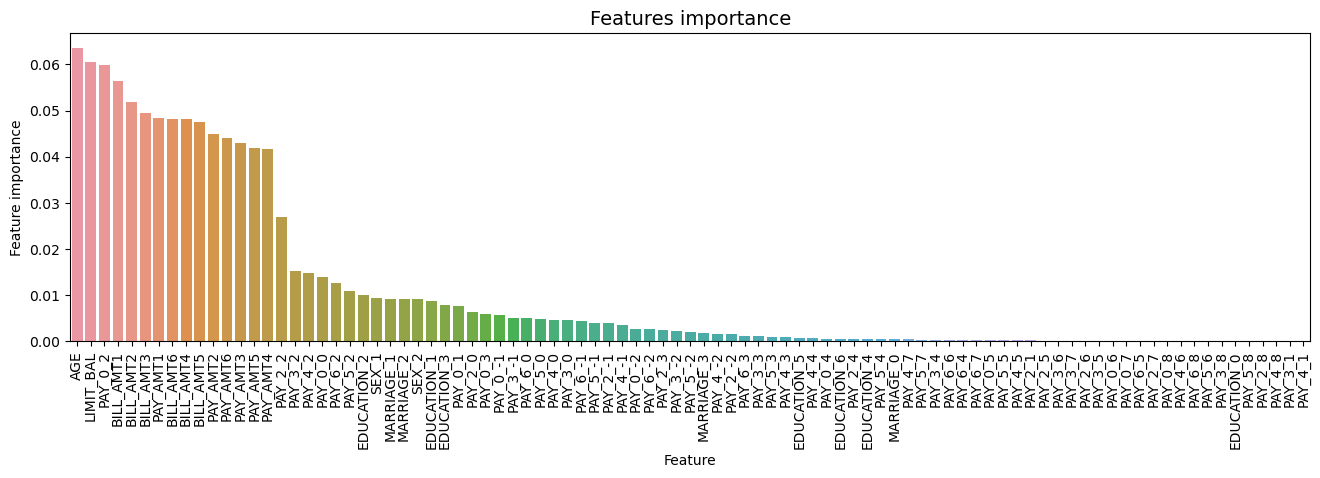

In [43]:
#Memvisualisasikan fitur penting.
tmp = pd.DataFrame({'Feature': predictors_f, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (16,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

Fitur yang paling penting adalah AGE, LIMIT_BAL, BILL_AMT1, PAY_0_2, BILL_AMT2, BILL_AMT3.

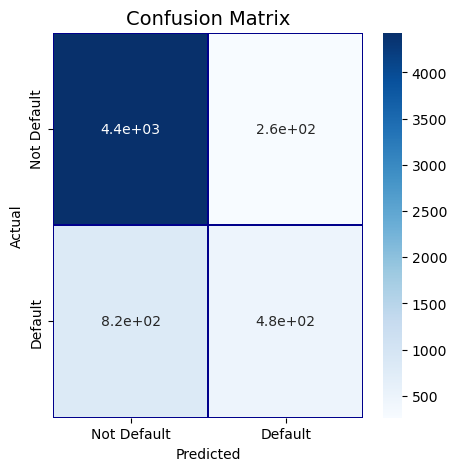

In [44]:
# Matrix Keputusan
cm = pd.crosstab(val_fa_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Default', 'Default'],
            yticklabels=['Not Default', 'Default'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [45]:
roc_auc_score(val_fa_df[target].values, preds)

0.6563712808035409

Dengan variabel tambahan (dummified), peningkatan skor AUC cukup kecil.

# AdaBoostClassifier

Membentuk parameter untuk pemodelan dan menginisialisasi model.

In [46]:
clf = AdaBoostClassifier(random_state=RANDOM_STATE,
                         algorithm='SAMME.R',
                         learning_rate=0.8,
                             n_estimators=NUM_ESTIMATORS)

In [47]:
# Model
clf.fit(train_df[predictors], train_df[target].values)

AdaBoostClassifier(learning_rate=0.8, n_estimators=100, random_state=2021)

# Memprediksi nilai target
Sekarang dilakukan prediksi nilai target untuk val_df data, menggunakan fungsi prediksi.

In [48]:
preds = clf.predict(val_df[predictors])

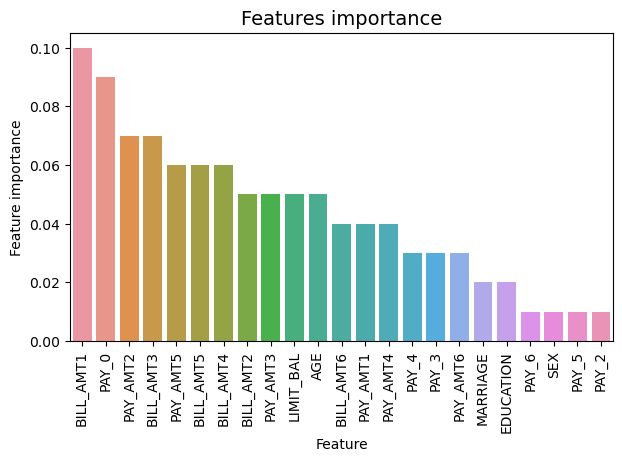

In [49]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()   

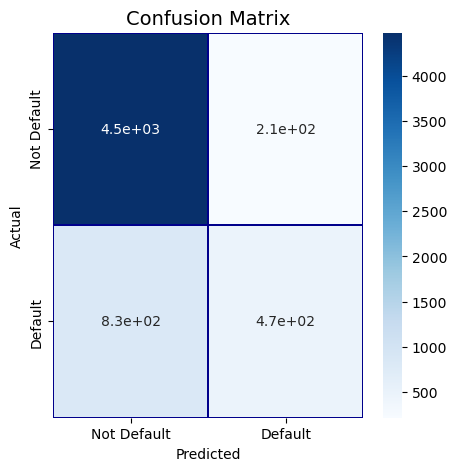

In [50]:
# MAtrix Keputusan 
cm = pd.crosstab(val_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Default', 'Default'],
            yticklabels=['Not Default', 'Default'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [51]:
roc_auc_score(val_df[target].values, preds)

0.6582553644580615

Skor ROC-AUC yang diperoleh dengan AdaBoostClassifier adalah 0,65.

# CatBoostClassifier

In [52]:
# Model
clf = CatBoostClassifier(iterations=500,
                             learning_rate=0.02,
                             depth=12,
                             eval_metric='AUC',
                             random_seed = RANDOM_STATE,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = VERBOSE_EVAL,
                             od_wait=100)

In [53]:
clf.fit(train_df[predictors], train_df[target].values,verbose=True)

0:	total: 426ms	remaining: 3m 32s
50:	total: 9.91s	remaining: 1m 27s
100:	total: 18.5s	remaining: 1m 12s
150:	total: 27.7s	remaining: 1m 4s
200:	total: 37.2s	remaining: 55.3s
250:	total: 47s	remaining: 46.7s
300:	total: 56.9s	remaining: 37.6s
350:	total: 1m 6s	remaining: 28.3s
400:	total: 1m 16s	remaining: 18.9s
450:	total: 1m 26s	remaining: 9.38s
499:	total: 1m 35s	remaining: 0us


In [54]:
# Prediksi nilai target
preds = clf.predict(val_df[predictors])

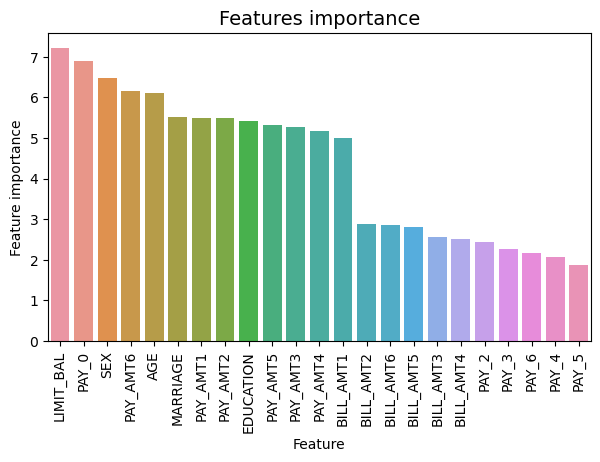

In [55]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()   

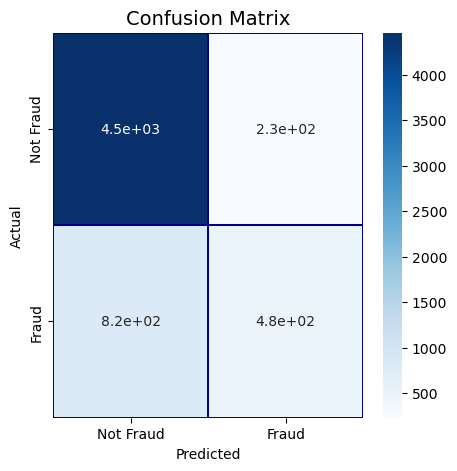

In [56]:
# Matrix
cm = pd.crosstab(val_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [57]:
roc_auc_score(val_df[target].values, preds)

0.659674072194975

Skor ROC-AUC yang diperoleh dengan CatBoostClassifier adalah 0,66.

# XGBoost

In [58]:
# Model
dtrain = xgb.DMatrix(train_df[predictors], train_df[target].values)
dvalid = xgb.DMatrix(val_df[predictors], val_df[target].values)

# Apa yang harus dipantau (dalam hal ini, ** training** dan ** validasi **)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# Atur parameter xgboost nya
params = {}
params['objective'] = 'binary:logistic'
params['eta'] = 0.039
params['silent'] = True
params['max_depth'] = 2
params['subsample'] = 0.8
params['colsample_bytree'] = 0.9
params['eval_metric'] = 'auc'
params['random_state'] = RANDOM_STATE

In [59]:
model = xgb.train(params, 
                dtrain, 
                MAX_ROUNDS, 
                watchlist, 
                early_stopping_rounds=EARLY_STOP, 
                maximize=True, 
                verbose_eval=VERBOSE_EVAL)

[18:31:52] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[0]	train-auc:0.69238	valid-auc:0.69939
[50]	train-auc:0.77015	valid-auc:0.76865
[100]	train-auc:0.77786	valid-auc:0.77322
[150]	train-auc:0.78333	valid-auc:0.77632
[200]	train-auc:0.78696	valid-auc:0.77830
[250]	train-auc:0.78972	valid-auc:0.77951
[300]	train-auc:0.79196	valid-auc:0.78067
[350]	train-auc:0.79400	valid-auc:0.78154
[400]	train-auc:0.79593	valid-auc:0.78218
[450]	train-auc:0.79752	valid-auc:0.78269
[500]	train-auc:0.79917	valid-auc:0.78319
[550]	train-auc:0.80071	valid-auc:0.78357
[600]	train-auc:0.80208	valid-auc:0.78377
[631]	train-auc:0.80296	valid-auc:0.78380


Skor validasi terbaik (ROC-AUC) adalah 0,78, pada iterasi 391.

(Nb: Setiap kali anda melekukan simulasi, kemungkinan besar akan memberikan hasil yang berbeda-beda). Tetapi hasil yang diperoleh tidak akan berbeda jauh.

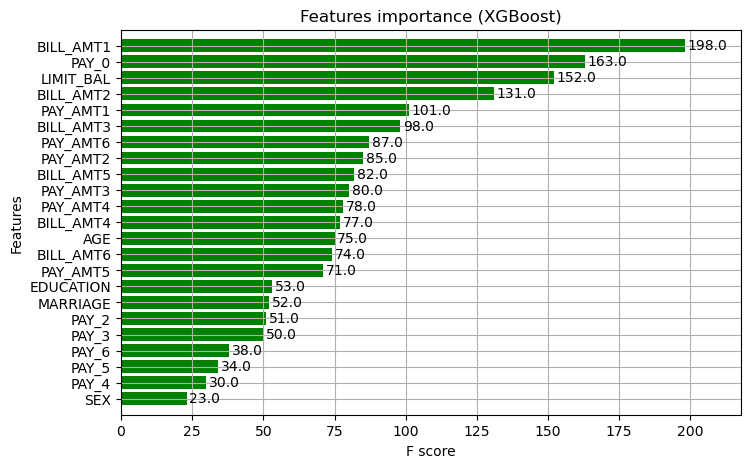

In [60]:
fig, (ax) = plt.subplots(ncols=1, figsize=(8,5))
xgb.plot_importance(model, height=0.8, title="Features importance (XGBoost)", ax=ax, color="green") 
plt.show()

# LightGBM

In [61]:
# parameter
params = {
          'boosting_type': 'gbdt',
          'objective': 'binary',
          'metric':'auc',
          'learning_rate': 0.05,
          'num_leaves': 7,                          # ini harus lebih kecil dari 2^(max_depth)
          'max_depth': 4,                           
          'min_child_samples': 100,                 # jumlah minimum data yang diperlukan (min_data_in_leaf)
          'max_bin': 100,                           # jumlah tempat penyimpanan untuk nilai fitur
          'subsample': 0.9,                         # rasio untuk subsampel yang di training
          'subsample_freq': 1,                      # frekuensi subsampel, <=0 tidak memungkinkan
          'colsample_bytree': 0.7,                  # rasio subsampel saat membuat setiap pohon keputusannya.
          'min_child_weight': 0,                    # Jumlah minimum bobot yang dibutuhkan setiap cabang (leaf)
          'min_split_gain': 0,                      # lambda_l1, lambda_l2 dan min_gain_to_split untuk regularisasi
          'nthread': 8,
          'verbose': 0,
          'scale_pos_weight':50,                    # because training data is sightly unbalanced 
         }

In [62]:
# Model
categorical_features = ['SEX', 'EDUCATION', 'MARRIAGE','PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

In [63]:
dtrain = lgb.Dataset(train_df[predictors].values, 
                     label=train_df[target].values,
                     feature_name=predictors,
                     categorical_feature=categorical_features)

dvalid = lgb.Dataset(val_df[predictors].values,
                     label=val_df[target].values,
                     feature_name=predictors,
                     categorical_feature=categorical_features)

In [64]:
#Bentuk Model
evals_results = {}

model = lgb.train(params, 
                  dtrain, 
                  valid_sets=[dtrain, dvalid], 
                  valid_names=['train','valid'], 
                  evals_result=evals_results, 
                  num_boost_round=MAX_ROUNDS,
                  early_stopping_rounds=EARLY_STOP,
                  verbose_eval=VERBOSE_EVAL, 
                  feval=None)

del dvalid
gc.collect()

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004348 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 50 rounds
[50]	train's auc: 0.778205	valid's auc: 0.772065
[100]	train's auc: 0.789331	valid's auc: 0.78026
[150]	train's auc: 0.794759	valid's auc: 0.783016
[200]	train's auc: 0.799694	valid's auc: 0.784026
[LightGBM] [Warning] No further splits with posi

50467

Skor validasi terbaik diperoleh untuk putaran 254, dimana AUC ~ = 0,78. 

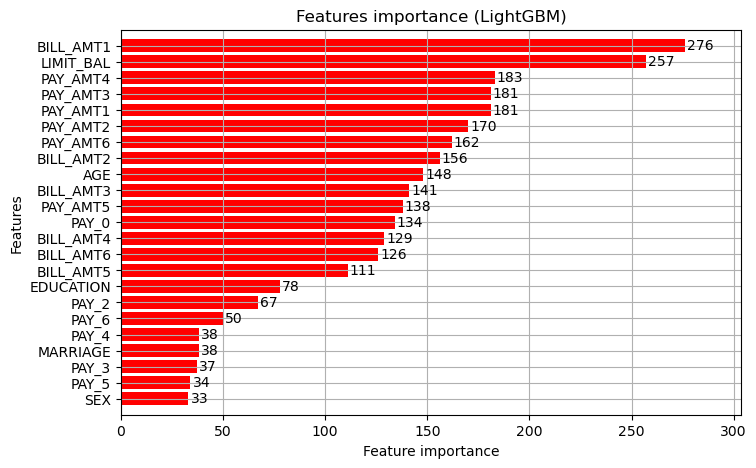

In [65]:
fig, (ax) = plt.subplots(ncols=1, figsize=(8,5))
lgb.plot_importance(model, height=0.8, title="Features importance (LightGBM)", ax=ax,color="red") 
plt.show()

# Pelatihan dan validasi menggunakan validasi silang (cross-validation)
Berikut digunakan validasi, akan menggunakan cross-validation (KFolds) dengan 5 kali pengulangan. Data dibagi dalam 5 bagian dan, secara rotasi, sehingga pengujian menggunakan pengulagan 4 (n-1) dan memvalidasi hingga menggunakan pengulagan ke-5 (n).

In [66]:
kf = KFold(n_splits = NUMBER_KFOLDS, random_state = RANDOM_STATE, shuffle = True)
for train_index, test_index in kf.split(data_df):
    train_X, valid_X = data_df.iloc[train_index], data_df.iloc[test_index]

    dtrain = lgb.Dataset(train_X[predictors].values, label=train_X[target].values,
                     feature_name=predictors)

    dvalid = lgb.Dataset(valid_X[predictors].values, label=valid_X[target].values,
                     feature_name=predictors)

    evals_results = {}
    model =  lgb.train(params, 
                  dtrain, 
                  valid_sets=[dtrain, dvalid], 
                  valid_names=['train','valid'], 
                  evals_result=evals_results, 
                  num_boost_round=MAX_ROUNDS,
                  early_stopping_rounds=EARLY_STOP,
                  verbose_eval=VERBOSE_EVAL, 
                  feval=None)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007902 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 50 rounds
[50]	train's auc: 0.777635	valid's auc: 0.771924
[100]	train's auc: 0.787959	valid's auc: 0.780115
[150]	train's auc: 0.793803	valid's auc: 0.783018
[200]	train's auc: 0.798692	valid's auc: 0.784212
[250]	train's auc: 0.802928	valid's auc: 0.784303
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[300]	train's auc: 0.806288	valid's auc: 0.784439
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[350]	train's auc: 0.810217	valid's auc: 0.785762
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[400]	train's auc: 0.813513	valid's auc: 0.785507
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[358]	train's auc: 0.810818	valid's auc:

Validasi rata-rata AUC untuk 5 kali pengulangan yang diperoleh adalah 0,80, dengan nilai antara 0,79 dan 0,80.

# Kesimpulan dan Saran
Setelah menyelidiki hasil, memeriksa data yang tidak seimbang, memvisualisasikan fitur dan memahami hubungan antara berbagai variabel.

Kemudian menyelidiki lima model prediksi sebagai berikut:

    *Dimulai dengan Random Forrest Classifier, untuk itu kami memperoleh kode AUC 0.66.

    *Untuk Random Forrest Classifier saya juga bereksperimen dengan OneHotEncoder, mengganti fitur-fitur  kategorikal dengan nilai-nilai dummifikasi (memperkenalkan satu variabel dummy untuk setiap kategori). Skor AUC 0.66, jadi tidak membaik secara signifikan dalam kasus ini.

    *Selanjutnya digunakan model AdaBoostClassifier, dengan skor AUC yang lebih rendah (0,65).

    *Berikutnya digunakan model CatBoostClassifier, dengan skor AUC yang lebih rendah (0,66).

    *Kemudian dilakukan dengan eksperimen dengan model XGBoost, di mana skor AUC yang diperoleh adalah 0,77.

    *Pada bagaian akhir dipresentasikan data ke model LightGBM diperoleh adalah 0,80.


Pada penelitian ini digunakan split validasi training dan validasi silang untuk mengevaluasi efektivitas model untuk memprediksi nilai target, yaitu mendeteksi apakah klien kartu kredit akan mengalami default bulan depan. Dengan kombinasi Metode Random Forrest Classfier dan LightGBM nilai yang diperoleh dari AUC untuk set validasi sekitar 0,80. Sehingga disimpulkan Metode Random Forrest Classfier dan LightGBM adalah model yang terbaik untuk melakukan prediksi apakah klien kartu kredit akan mengalami default bulan depan.